In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
h = 0.0000001
x = 3.0
(f(x+h)-f(x))/h #this is the definition of derivative

In [ ]:
# def slope(a,b,c,h,a1,b1,c1):
#     d1 = a*b + c
#     d2 = a1*b1 + c1
#     print('d1', d1)
#     print('d2', d2)
#     print('slope', (d2-d1)/h)

# a = 2.0
# b = -3.0
# c = 10.0
# h = 0.0001

# slope(a,b,c,h,a+h,b,c)
# slope(a,b,c,h,a,b+h,c)
# slope(a,b,c,h,a,b,c+h)

In [ ]:
class Value:

    def __init__(self,data,_children=(),_op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/ float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
# a = Value(2.0, label='a')
# b = Value(-3.0, label='b')
# c = Value(10, label='c')
# e=a*b
# e.label='e'
# d=e+c
# d.label='d'
# f = Value(-2.0, label='f')
# L = d*f; L.label='L'
# L
# # c,c._prev,c._op,d,d._prev,d._op

In [4]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = '{%s | data %.4f | grad %.4f}' % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [ ]:
# L.grad = 1.0 #dL/dL
# f.grad = d.data #dL/df
# d.grad = f.data #dL/dd
# c.grad = f.data #dL/dc
# e.grad = f.data #dL/de
# b.grad = (a*f).data #dL/db
# a.grad = (b*f).data #dL/da

In [ ]:
# draw_dot(L)

In [ ]:
# a.data -= 0.01*a.grad
# b.data -= 0.01*b.grad
# c.data -= 0.01*c.grad
# f.data -= 0.01*f.grad

# e = a * b
# d = e + c
# L = d * f

# L #this is if we want to reduce L from -8 to something more negative

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

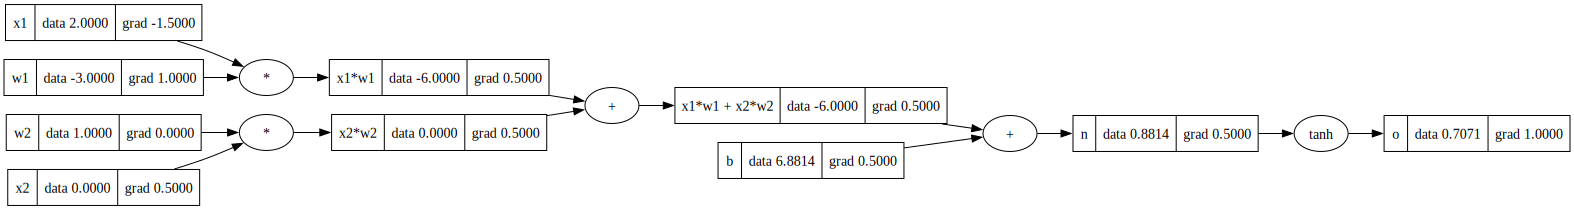

In [12]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1
x2w2 = x2*w2
x1w1.label = 'x1*w1'
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
# o.grad = 1.0
# #do/dn = 1 - tanh(n)^2 = 1 - o*o
# n.grad = 0.5 #1 - (o*o).data
# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# x2w2.grad = 0.5
# x1w1.grad = 0.5
# x2.grad = 0.5*w2.data
# w2.grad = 0.5*x2.data
# x1.grad = 0.5*w1.data
# w1.grad = 0.5*x1.data

In [ ]:
# o.grad = 1.0
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()
# x2._backward()
# w2._backward()
# x1._backward()
# w1._backward()
# draw_dot(o)

In [ ]:
# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)

# build_topo(o)
# print(topo)
# print(visited)

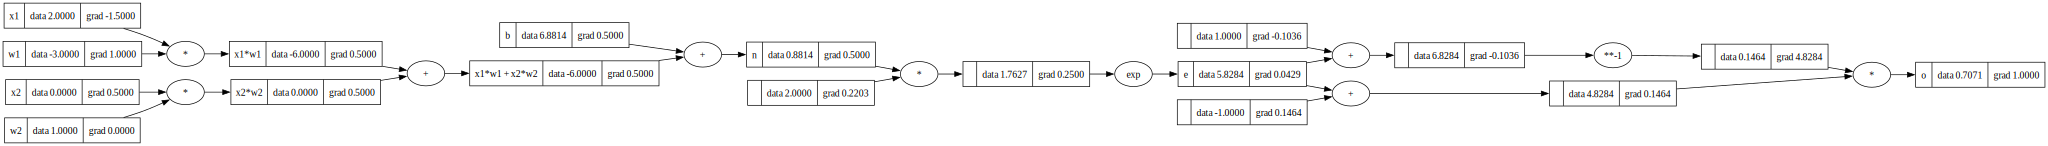

In [14]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1
x2w2 = x2*w2
x1w1.label = 'x1*w1'
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'
e = (2*n).exp()
e.label = 'e'
o = (e-1)/(e+1)
o.label = 'o'
o.backward()
draw_dot(o)

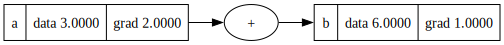

In [7]:
a = Value(3.0, label='a')
b = a+a
b.label = 'b'
b.backward()
draw_dot(b)

In [11]:
a = Value(2.0)
b = a-3
c = -b
c

Value(data=1.0)

In [ ]:
import torch

x1 = torch.Tensor([2.0]).double() #so that it is float64 and not float32
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.881373580195432]).double()
b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
